In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fitting
from iminuit import Minuit
import scipy.stats as stats

# Bayesian fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand

# Loading bar
from tqdm.notebook import tqdm

In [2]:
# Import my own functions developed for AppStat2020
import sys

# Load own library
sys.path.append('../AppStat_Functions')
import General_functions as AppStars

In [3]:
SaveFig = True

# Import Data

In [4]:
data = np.genfromtxt('Data/Exam_2022_Prob3.txt')
data

array([2.364848, 1.989056, 2.817711, ..., 1.194349, 1.452574, 2.302067])

# Definitions

In [5]:
# Define the bounds
xlim = (1,3)
alim = (0,15)
blim = (9,27)

# Make an array within the bounds
x_arr = np.linspace(*xlim, 100)

# Fitting with Minuit

In [6]:
# Define the function
def f(x,a,b):
    
    num = np.cos(a*x)*np.cos(b*x)
    denom = x**2
    
    return num/denom + 2

# Define the function normalised
def norm_f(x, a, b):
    
    # Get area nummerically
    A = np.trapz(f(x_arr, a, b), x_arr)
    
    # Normalise
    return 1/A * f(x, a, b)

# Define the target function to minimize - neg llh
def target_func(a, b):
    
    # Make pdf in the truncated interval
    pdf = norm_f(data, a, b)

    # Calculate the log likelihood 
    llh = np.sum(np.log(pdf))
    
    # Return negative llh, when minimizing = max likelihood
    return -llh

In [7]:
# Initialise target with right errors (UP=0.5 for likelihood)
# See p. 39 here https://root.cern.ch/download/minuit.pdf
target = target_func
target.errordef = Minuit.LIKELIHOOD

# Define parameters initial guess - in the middle of bound for now
params = {'a': np.mean(alim), 'b': np.mean(blim)}

# Initialize minimizer
minimizer = Minuit(target, **params)

# Enforce bounds
minimizer.limits['a'] = alim
minimizer.limits['b'] = blim

# Actually minimize
minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5207                       │              Nfcn = 66               │
│ EDM = 1.52e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   4.97    │   0.21    │            │            │    0    │   15    │       │
│ 1 │ b    │   17.31   │   0.13    │            │            │    9    │   27    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │   0.0448 -0.00919 │
│ b │ -0.00919    0.018 │
└───┴───────────────────┘

In [8]:
# Extract values
a_val_err = (minimizer.values[0], minimizer.errors[0])
b_val_err = (minimizer.values[1], minimizer.errors[1])

## Chi2 Test

In [9]:
# Extract values from histogram and outline data
N_bins = 50
counts, bin_edges = np.histogram(data, bins=N_bins);
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
binwidth = bin_edges[1] - bin_edges[0]

# Poisson errors on the count in each bin
s_counts = np.sqrt(counts)
    
# We remove any bins, which don't have any counts in them:
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

# Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
f_plot = norm_f(x, a_val_err[0], b_val_err[0])
y_exp = f_plot * len(data) * binwidth 

# Degrees of freedom
N_ddof = len(x) - 2 #n_point - n_parameters, notice n_points is the no. of bin centers

# Calc chi2 and p value
chi2 = np.sum( (y-y_exp)**2 / y_exp )
prob = stats.chi2.sf(chi2, df=N_ddof) 
print(f'The Chi2 is: {chi2:.4f} with a p-value of: {prob:.4f}')

The Chi2 is: 99.7347 with a p-value of: 0.0000


## Plot the Results

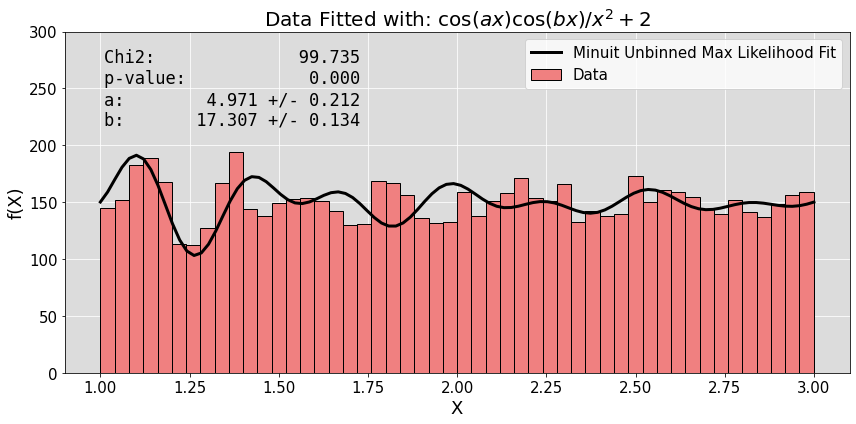

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot the data
ax.hist(data, N_bins, color='lightcoral', ec='k', zorder=2, label='Data')

# Plot the fit
y_arr = norm_f(x_arr, a_val_err[0], b_val_err[0]) * len(data) * binwidth 
ax.plot(x_arr, y_arr, color='k', linewidth=3, zorder=3, label='Minuit Unbinned Max Likelihood Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2:': chi2,
     r'p-value:': prob,
     r'a:': f'{a_val_err[0]:.3f} +/- {a_val_err[1]:.3f}',
     r'b:': f'{b_val_err[0]:.3f} +/- {b_val_err[1]:.3f}',
    }

text = AppStars.nice_string_output(d, extra_spacing=1, decimals=3)
AppStars.add_text_to_ax(0.05, 0.95, text, ax, fontsize=17, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data Fitted with: $\cos(ax)\cos(bx)/x^2+2$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('f(X)', fontsize=18)

plt.ylim(0,300)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/3_1.pdf')

plt.show()

# Fitting with Nested Sampling (UltraNest)

In [11]:
# Def the param names
param_names = ['a', 'b']

# Define the bounds on the parameters from the slide
bounds = [alim, blim]

# Define the prior, we assume uniform within bounds
def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    # Copy parameters
    params = cube.copy()
    
    # Transform 'a'
    lo = bounds[0][0]
    hi = bounds[0][1]
    params[0] = cube[0] * (hi - lo) + lo
    
    # Transform 'b'
    lo = bounds[1][0]
    hi = bounds[1][1]
    params[1] = cube[1] * (hi - lo) + lo
    
    return params

# Define likelihood
def log_likelihood(params):
    
    # Compute for each x point, where it should lie in y
    y_model = norm_f(data,*params)
    
    # Compute likelihood
    # THIS IS DONE DIFFERENTLY IN THE EXAMPLE SOMETHING ABOUT ERRORS
    llh = np.sum(np.log(y_model)) 
    return llh

In [12]:
# Initialise sampler
sampler = ultranest.ReactiveNestedSampler(param_names, log_likelihood, prior_transform)

# Seed
np.random.seed(1)

# Run it
result = sampler.run(min_num_live_points=400)
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+03  169.96 [-5169.9711..-5169.9711]*| it/evals=5280/14634 eff=37.0943% N=400 
[ultranest] Likelihood function evaluations: 14636
[ultranest]   logZ = -5179 +- 0.09987
[ultranest] Effective samples strategy satisfied (ESS = 1569.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -5178.566 +- 0.172
  single instance: logZ = -5178.566 +- 0.138
  bootstrapped   : logZ = -5178.551 +- 0.172
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    a                   : 4.764 │ ▁ ▁▁▁▁▁▁▁▂▂▂▄▄▅▅▆▇▇▇▇▇▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁ │5.480     5.125 +- 0.086
    b                   : 22.160│ ▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁  ▁ │22.784    22.457 +- 0.076



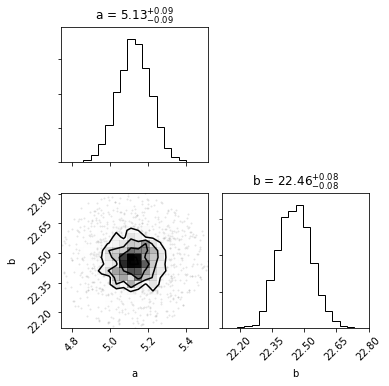

In [13]:
# Display results in cornerplot
cornerplot(result)
if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/3_2.pdf')

In [14]:
# Get results as pandas frame
df_fit = pd.DataFrame(data=result['samples'], columns=result['paramnames'])
df_fit.describe()

# Extract the fit parameters
a_val_err = (np.mean(df_fit['a']), np.std(df_fit['a']))
b_val_err = (np.mean(df_fit['b']), np.std(df_fit['b']))
print(f'a is: {a_val_err[0]:.4f} +/- {a_val_err[1]:.4f}')
print(f'b is: {b_val_err[0]:.4f} +/- {b_val_err[1]:.4f}')

a is: 5.1255 +/- 0.0864
b is: 22.4570 +/- 0.0764


## Chi2 Test

In [15]:
# Extract values from histogram and outline data
N_bins = 50
counts, bin_edges = np.histogram(data, bins=N_bins);
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
binwidth = bin_edges[1] - bin_edges[0]

# Poisson errors on the count in each bin
s_counts = np.sqrt(counts)
    
# We remove any bins, which don't have any counts in them:
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

# Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
f_plot = norm_f(x, a_val_err[0], b_val_err[0]) 
y_exp = f_plot * len(data) * binwidth 

# Degrees of freedom
N_ddof = len(x) - 2 #n_point - n_parameters, notice n_points is the no. of bin centers

# Calc chi2 and p value
chi2 = np.sum( (y-y_exp)**2 / y_exp )
prob = stats.chi2.sf(chi2, df=N_ddof) 
print(f'The Chi2 is: {chi2:.4f} with a p-value of: {prob:.4f}')

The Chi2 is: 31.6413 with a p-value of: 0.9670


## Plot the Results

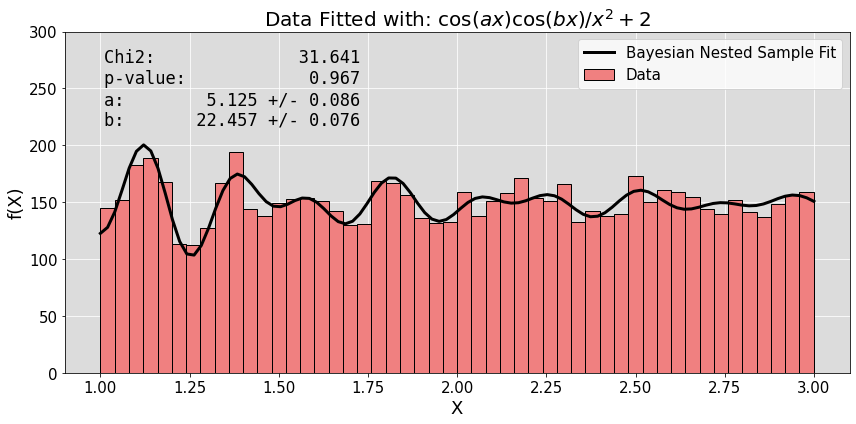

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot the data
ax.hist(data, N_bins, color='lightcoral', ec='k', zorder=2, label='Data')

# Plot the fit
y_arr = norm_f(x_arr, a_val_err[0], b_val_err[0]) * len(data) * binwidth 
ax.plot(x_arr, y_arr, color='k', linewidth=3, zorder=3, label='Bayesian Nested Sample Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2:': chi2,
     r'p-value:': prob,
     r'a:': f'{a_val_err[0]:.3f} +/- {a_val_err[1]:.3f}',
     r'b:': f'{b_val_err[0]:.3f} +/- {b_val_err[1]:.3f}',
    }

text = AppStars.nice_string_output(d, extra_spacing=1, decimals=3)
AppStars.add_text_to_ax(0.05, 0.95, text, ax, fontsize=17, color='k')

# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data Fitted with: $\cos(ax)\cos(bx)/x^2+2$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('f(X)', fontsize=18)

plt.ylim(0,300)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/3_3.pdf')
    
plt.show()

# 2D Raster Scan

In [17]:
# Define ln-likelihood function
def ln_likelihood(a,b):
    
    # Calc PDF from mass
    PDF = norm_f(data, a, b)
    
    # Return log likelihood
    return np.sum( np.log(PDF) ) 

# Define the function for the raster scan
def raster_2D(target, xbound, ybound, dx):
    """
    INPUTS:
    target = function to scan, taking two parameters
    xbound = bound on the first parameter
    ybound = bound on the second parameter
    dx = step size
    
    OUTPUT:
    XX = x parameter in grid shape, is a matrix
    YY = y parameter in grid shape, is a matrix
    ZZ = the target function evaluated at all combinations of parameters, is a matrix
    """
    
    # Make meshgrid for the scan
    X = np.arange(*xbound, dx)
    Y = np.arange(*ybound, dx)
    XX, YY = np.meshgrid(X,Y)
    
    # Make grids one dimensional, for easy looping
    X_values = XX.reshape(-1)
    Y_values = YY.reshape(-1)
    
    # Array to store Z values
    Z_values = np.zeros_like(X_values)
    
    # Loop over combinations
    print('----- EVALUATING TARGET FUNCTION -----')
    for i in tqdm(range(len(X_values))):
        
        # Compute Z for given X and Y
        Z_values[i] = target(X_values[i], Y_values[i]) 
    
    # Reshape Z values back to grid shape
    ZZ = Z_values.reshape(np.shape(XX))
    
    return XX, YY, ZZ

In [18]:
# Define the range for the raster scane
a_scan = (a_val_err[0]-3,a_val_err[0]+3)
b_scan = (b_val_err[0]-3.5,b_val_err[0]+3.5)

# Define step
step_size = 0.1

# Perform raster scan
a_mat, b_mat, llh_mat = raster_2D(ln_likelihood, a_scan, b_scan, step_size)

----- EVALUATING TARGET FUNCTION -----


  0%|          | 0/4270 [00:00<?, ?it/s]

In [19]:
# Get best fit parameters
best_raster_coords = np.unravel_index(np.argmax(llh_mat, axis=None), llh_mat.shape)
raster_a_val = a_mat[best_raster_coords]
raster_b_val = b_mat[best_raster_coords]

## Plot results

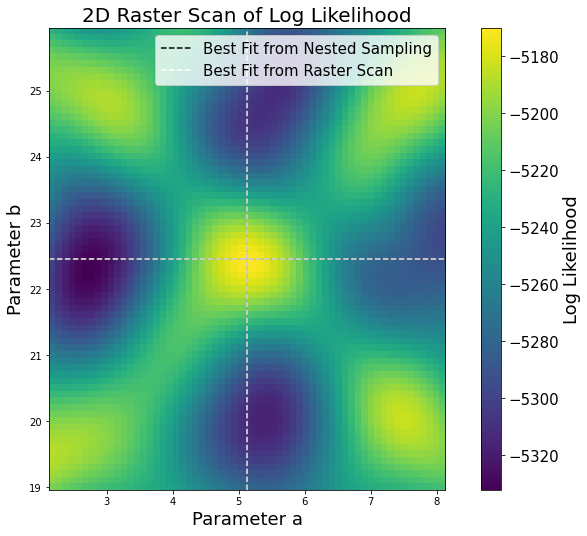

In [20]:
fig, ax = plt.subplots(figsize=(8,8))

# Plot Data ---------------
# extent = [x_min , x_max, y_min , y_max]
im = ax.imshow(llh_mat, extent = [a_scan[0],a_scan[1],b_scan[0],b_scan[1]] )

# Colorbar -----------------
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = fig.colorbar(im, cax)
cbar.set_label('Log Likelihood', fontsize=18)

# Mark best fit from nested sampling
ax.hlines(b_val_err[0], a_scan[0],a_scan[1], color='k', linestyle='dashed', label='Best Fit from Nested Sampling')
ax.vlines(a_val_err[0], b_scan[0],b_scan[1], color='k', linestyle='dashed')

# Mark best fit from raster scan
ax.hlines(raster_b_val, a_scan[0],a_scan[1], color='w', linestyle='dashed', label='Best Fit from Raster Scan')
ax.vlines(raster_a_val, b_scan[0],b_scan[1], color='w', linestyle='dashed')


# Pretty -------------------
ax.legend(prop={'size':15})
ax.set_title('2D Raster Scan of Log Likelihood', fontsize=20)
ax.set_xlabel('Parameter a', fontsize=18)
ax.set_ylabel('Parameter b', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/3_4.pdf')

plt.show()

In [21]:
raster_a_val,raster_b_val

(5.125481574055415, 22.45702903706618)

In [22]:
a_val_err[0], b_val_err[0]

(5.125481574055413, 22.457029037066132)

We have confirmed what we already knew. I am thinking that maybe the raster scan of the test statistic would in fact be a raster scan of the bayesian evidence as a test statistic. Is that possible?